In [1]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import rice, foldnorm
from dw_tools      import dag_pgm_tools, draw_tree
import networkx as nx
import reciprocalspaceship as rs
import gemmi

In [2]:
plt.rcParams.update({'font.size': 14})
%load_ext autoreload
%autoreload 2

## Taking a "tree" point of view...
In this notebook, we are concerned with sets of reflections that are "closely related". Thinking of tables of reflections, like in a ```reciprocalspaceship```'s ```dataSet```, these are reflections in the same row--they have the same Miller index or Miller indices that can be mapped to each other under a crystallographic symmetry operation. These reflections may have been collected for different crystals, at different time points, or be related by symmetry only under some conditions (e.g. no electric field).

For the sake of introduction, we will consider the following three sets of complex structure factors $F_1$,$F_2$,$F_3$. We may have some knowledge that of the correlations among these datasets such that we can approximate their statistical relationships using a conditional independence diagram, such that 
<img src="img/F1_F2_F3.png" alt="drawing" width="200"/>

with arrows indicating statistical dependence, parameterized by a DW parameter indicated by the superscripts (note that correlations are equal in both directions). 

A special case we'll examine later in this notebook is that of Friedel mates,
<img src="img/friedel_2.png" alt="drawing" width="250"/>

We'll understand $F^+$ to denote structure factor amplitudes lying in the $h\geq 0$ hemisphere (and the ASU that lies therein), and $F^-$ its Friedel mate in the complementary hemisphere. Note that some reflections map onto themselves when also accounting for crystallographic symmetry. What follows in this notebook does not apply to reflections that map to themselves. 

### Normalization
For the remainder, we will assume that the structure factors live on a common scale set by $\Sigma=\mathbb{E}(|F|^2)$. To indicate this, we'll switch from $F$ to $E$. We'll keep the common scale $\Sigma$ around, noting that for normalized structure factors $\Sigma=1$.

### Another view of the same
It is sometimes helpful to think of $E_2$ as consisting of 
- a chunk depending on $E_1$ with magnitude $r E_1$ and variance $r^2 \frac{\Sigma}{2}$ for real and imag components and,
- an independent bivariate normal chunk $\Delta_{21}$ with mean $(0,0)$ and covariance matrix $\frac{1}{2}(1-r^2)\Sigma \mathbf{I}$, 

with $\mathbf{I}$ the identity matrix. That is, $E_2 = r\cdot E_1 + \eta\cdot\sqrt{\frac{1}{2}(1-r^2)\Sigma}$, with $\eta$ a sample drawn from a bivariate standard normal. This result follows from the properties of conditional normal distributions (https://en.wikipedia.org/wiki/Multivariate_normal_distribution). 

### Factorizing the joint probability
Thinking of each complex structure factor as consisting of an amplitude and a phase (e.g. $E_i$ described by its amplitude and phase, $(R_i,\phi_i)$), we can use conditional independence to state that:

$$
P\left(E_1,E_2,E_3\right) = 
P\left(E_3\bigr| E_2\right)\cdot
P\left(E_2\bigr| E_1\right) P\left(E_1\right)
=
P\left(R_3,\phi_3\bigr| R_2,\phi_2\right)\cdot
P\left(R_2,\phi_2\bigr| R_1,\phi_1\right)\cdot P\left(R_1,\phi_1\right)
$$

(depending on circumstances, this is either an approximation or an identity).

We already know that in the DW model $P\left(R_3,\phi_3\bigr| R_2, \phi_2\right)=P\left(R_3,\Delta\phi_{32}=\phi_3-\phi_2\bigr| R_2\right)$, etc.. That is, only the phase difference matters for the probability, not the specific value of $\phi_2$. We now have:

$$
P\left(E_2,E_3\bigr|E_1\right) = 
P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right)\cdot
P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) 
$$

so, when we integrate over the unknown phase differences, we get for the amplitudes:

\begin{equation}
P\left(R_2,R_3\bigr|E_1\right) = \int d\Delta\phi_{32} P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right)\cdot
                                 \int d\Delta\phi_{21} P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) 
\tag{1a}                                
\end{equation}


$P\left(E_2\bigr|E_1\right)$ and $P\left(E_3\bigr|E_2\right)$ are, for the complex structure factors, conditional bivariate normal distributions. For the amplitudes, the results of _both_ integrals in eq. 1a are Rice distributions (acentric case) or Folded Normals (centric case). For now, we'll focus on the acentric case.

In our example, 

$$
\int d\Delta\phi_{32} P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right) = Rice\left(\nu = r_x R_2, \sigma^2 = \frac{\Sigma}{2}(1-r_x^2)\right)
\tag{1b}  
$$
and
$$
\int d\Delta\phi_{21} P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) = Rice\left(\nu = r R_1, \sigma^2 = \frac{\Sigma}{2}(1-r^2)\right)
\tag{1c}  
$$

See https://en.wikipedia.org/wiki/Rice_distribution#Related_distributions, and Rupp Ch. 7, as well as sections 1.1 and 1.2 of https://www.sciencedirect.com/science/article/pii/S0076687997760695.

#### Comparison to sampled data
Let's first examine this example by making a comparison to surrogate data. As described in 8_DAG_PGM_structure_factor_distributions, we can calculate the joint distribution of the real and imaginary components of $E_2$ and $E_3$ _conditional on $E_1$_ using the properties of the multivariate normal (https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions).

For simplicity, we assume $E_1$ is real and has a value of 1.5, as currently written:

In [31]:
rng  = default_rng()
r    = 0
rx   = 0.99
R1   = np.asarray([1.5,1.5,0,0])       # unconditional: value of R1 (organized as E_1x,E_1x,E_1y,E_1y)
mean = np.array([r,r*rx,r,r*rx])*R1    # conditional means of components of E2 and E3
cov  = 0.5*\
    np.asarray([[ 1-r**2    , rx*(1-r**2),  0,           0          ],\
                [rx*(1-r**2), 1-rx**2*r**2, 0,           0          ],\
                [0,           0,            1 -r**2,     rx*(1-r**2)],\
                [0,           0,            rx*(1-r**2), 1-rx**2*r**2]])

In [32]:
n_samples = 10000000
vals   = rng.multivariate_normal(mean,cov,n_samples)
R2_sq  = vals[:,0]**2 + vals[:,2]**2
R3_sq  = vals[:,1]**2 + vals[:,3]**2
R2_abs = np.sqrt(R2_sq)
R3_abs = np.sqrt(R3_sq)

We can now implement eqs. 1a-c and compare to the sampled surrogate data.

In [33]:
def bivariate_Rice_DAG(R1, R2, R3, Sigma=1, r=0.9, rx=0.99):
    cond_mean_21 = (R1 * r)
    cond_mean_32 = (R2 * rx)
    nu_21        = cond_mean_21
    nu_32        = cond_mean_32
    cond_var_21  = 0.5*Sigma*(1-r**2 )
    cond_var_32  = 0.5*Sigma*(1-rx**2)
    sigma_ac_21  = np.sqrt(cond_var_21)
    sigma_ac_32  = np.sqrt(cond_var_32)
    # convert to scipy.stats convention:
    b_21         = nu_21/sigma_ac_21
    b_32         = nu_32/sigma_ac_32
    scale_21     = sigma_ac_21
    scale_32     = sigma_ac_32

    return rice.pdf(R3, b=b_32, scale=scale_32)*rice.pdf(R2, b=b_21, scale=scale_21)

Let's calculate this PDF on a grid.

In [34]:
nx, ny       = (200,300)
x_max, y_max = (5, 6)
xbase  = np.linspace(0.001, x_max, nx)
ybase  = np.linspace(0.001, y_max, ny)
xx,yy  = np.meshgrid(xbase, ybase)
y_in   = np.transpose(np.array([np.transpose(xx).flatten(), np.transpose(yy).flatten()]))
print(xx.shape)
print(y_in.shape)

t1_start = perf_counter()  
result = bivariate_Rice_DAG(R1[0], y_in[:,0].reshape(1,-1), y_in[:,1].reshape(1,-1), Sigma=1, r=r, rx=rx)
result = result.reshape(nx,ny)
t1_end = perf_counter()  
print(result.shape)

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result[:])*((x_max/nx)*(y_max/ny)):.3}")

(300, 200)
(60000, 2)
(200, 300)
Elapsed time: 0.0132 s
Integrated probability density: 0.992


We will also compare to the general solution implemented in ```dag_pgm_tools.RiceWoolfson_for_DAG``` and explained in **8_DAG_PGM_structure_factor_distributions**. To be able to do so, we need to summarize the properties of the graph underlying the PGM. Specifically,

In [36]:
list_of_nodes = [0,1,2]
list_of_edges = [(0,1),(1,2)]
root          = 0
list_of_rDW   = [r,rx]  # one element per edge
root_R        = R1[0]   # if we condition on the value of the root, we need to add this. 
                        # For unconditional PDF, use root_R=None

In [37]:
nx, ny       = (200,300)
x_max, y_max = (5, 6)
xbase  = np.linspace(0.001, x_max, nx)
ybase  = np.linspace(0.001, y_max, ny)
xx,yy  = np.meshgrid(xbase, ybase)
y_in   = np.transpose(np.array([np.transpose(xx).flatten(), np.transpose(yy).flatten()]))
print(xx.shape)
print(y_in.shape)

t1_start = perf_counter()  
result_2 = dag_pgm_tools.RiceWoolfson_for_DAG(list_of_nodes, list_of_edges, root=root, list_of_rDW=list_of_rDW, \
                                              root_R=root_R, root_rDW=None, Sigma=1, centric=False\
                                             ).prob(np.concatenate((np.zeros((y_in.shape[0],1)), y_in),axis=1))
result_2 = result_2.reshape(nx,ny)
# print(result_2.shape)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result_2[:])*((x_max/nx)*(y_max/ny)):.3}")

(300, 200)
(60000, 2)
Overwrote the 0th column with the reference.
Elapsed time: 0.028 s
Integrated probability density: 0.992


Let's compare the bivariate and general PDFs to the samples:

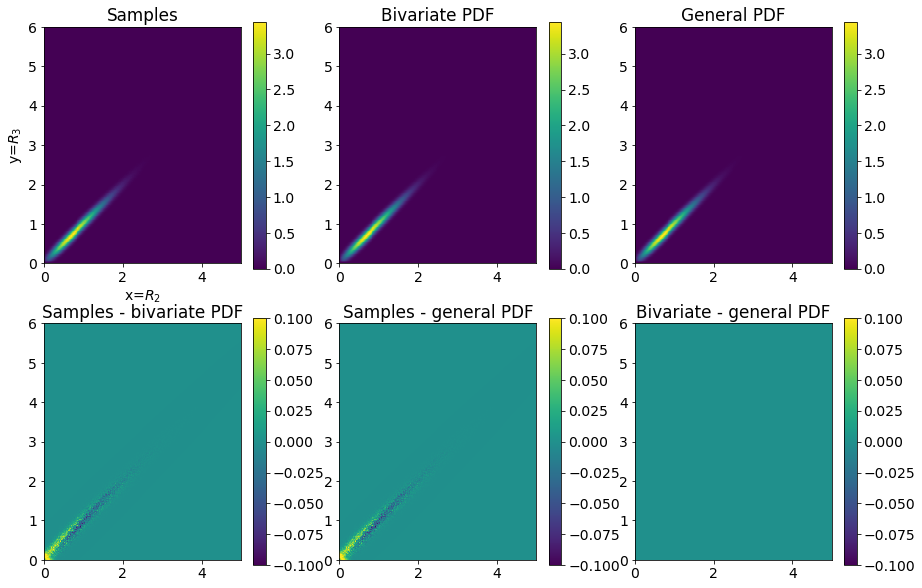

In [38]:
(xmax,ymax) = (x_max,y_max)
xedges = np.linspace(0,xmax,nx+1)
yedges = np.linspace(0,ymax,ny+1)
Hx_emp, xedges, yedges = np.histogram2d(R2_abs, R3_abs, bins=(xedges, yedges),density=True)

# Since the axes of these plots drive me a nuts, a positive control using [yplot.hist2d.
# In addition, I made the 2D histograms below asymmetric in dimension (remove "extent=[]" to see that),
# and validated labels using 1D histograms above.
# fig,ax=plt.subplots()
# ax.hist2d(R2_abs, R3_abs,bins=50,range=[[0,xmax],[0,ymax]])
# ax.set_aspect('equal')
# ax.set_xlabel(r"$R_2$"); ax.set_ylabel(r"$R_3$")
# plt.show()

plt.figure(figsize=(15,10))                         
plt.subplot(2,3,1)        
plt.imshow(Hx_emp.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) 
plt.xlabel(r"x=$R_2$"); plt.ylabel(r"y=$R_3$")
plt.title("Samples"); plt.colorbar(); 

plt.subplot(2,3,2)        
plt.imshow(result.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.title("Bivariate PDF"); plt.colorbar()

plt.subplot(2,3,3)        
plt.imshow(result_2.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.title("General PDF"); plt.colorbar()

plt.subplot(2,3,4)
plt.imshow((Hx_emp-result).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax], vmin=-0.1, vmax=0.1)
plt.title("Samples - bivariate PDF"); plt.colorbar(); 

plt.subplot(2,3,5)
plt.imshow((Hx_emp-result_2).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax], vmin=-0.1, vmax=0.1)
plt.title("Samples - general PDF"); plt.colorbar(); 

plt.subplot(2,3,6)
plt.imshow((result-result_2).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax], vmin=-0.1, vmax=0.1)
plt.title("Bivariate - general PDF"); plt.colorbar(); plt.show()

We see that the synthetic data, ```bivariate_Rice_DAG``` and the general function ```dag_pgm_tools.RiceWoolfson_for_DAG.prob()``` yield consistent results and match the sample distribution up to sampling and gridding errors.

## General case (see ```8_DAG_PGM_structure_factor_distributions```)
#### Acentric case:
As we saw in "_Factorizing the joint probability_" for the bivariate case, the results of _both_ integrals are Rice distributions. The above principle generalizes to directed trees. Let's mark the parent of each node $R_i$ as $\mathrm{Pa}(R_i)$; let the "origin" be $R_0$, and refer to the DW parameter for $P\left(R_i \ \bigr|\ \mathrm{Pa}(R_i)\right)$ as $r_i$, then,

$$
P\left(R_i \ \bigr|\ \mathrm{Pa}(R_i)\right) = \int d\Delta\phi_{i,\mathrm{Pa}(i)} P\left(R_i,\Delta\phi_{i,\mathrm{Pa(i)}}\bigr| \mathrm{Pa}(R_i)\right) = Rice\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \frac{\Sigma}{2}(1-r_i^2)\right)
$$
and

$$
P\left(\{R_i: \ i>0\} \bigr| R_0\right) = \prod_{i>0} Rice\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \frac{\Sigma}{2}(1-r_i^2)\right)
\tag{2a}
$$

That is, to specify a joint prior, all we need to do is to specify the reference prior (optional!), the tree structure $\left\{\left(i, \mathrm{Pa}(i)\right)\right\}$, and estimates of the $r_i$. In the limit of $r_i\rightarrow 0$, the priors return to the Wilson distribution. 

#### Centric case:
The centric case is entirely analogous:
$$
P\left(R_i \bigr| \mathrm{Pa}(R_i)\right) = \int d\Delta\phi_{i,\mathrm{Pa}(i)} P\left(R_i,\Delta\phi_{i,\mathrm{Pa(i)}}\bigr| \mathrm{Pa}(R_i)\right) = \mathrm{FoldedNormal}\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \Sigma(1-r_i^2)\right)
$$
and

$$
P\left(\{R_i: \ i>0\} \bigr| R_0\right) = \prod_{i>0} \mathrm{FoldedNormal}\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \Sigma(1-r_i^2)\right)
\tag{2b}
$$

## Priors for variational inference
Equations 2a-b specify the priors for variational inference. A specific implementation for Friedel mates is described below.

## Variational distributions / surrogate posteriors

In terms of functional forms to use, the simplest thing to do is to extend the use of truncated ($TruncNorm$) or folded normal distributions to the bivariate and multivariate cases. Multivariate extensions of the folded normal are easy to implement yourself by adding all probability for the other quadrants, octants, etc. to the first one ($(\mathbb{R}^+)^d$). 

However, there is one important question--what kind of covariance structure should we use? I propose that we take a page from the case where one estimates the mean $(\mu_x,\mu_y)$ of a bivariate normal distribution from a set of observations $x_n, n=1,...,N$ and $y_{n'}, n'=1,...,N'$ (it doesn't matter whether $N$ and $N'$ match). That is, we have a likelihood 

$$
L = -2 \log P\left(\{x_n\},\{y_n\}\big| \mu_x, \mu_y\right) = \sum_n\left(\frac{x_n-\mu_x}{\sigma_x}\right)^2 + \sum_{n'}\left(\frac{y_{n'}-\mu_y}{\sigma_y}\right)^2
$$.  

Let's say we have a normal prior on the means as well, for example:

$$
-2 \log P\left(\mu_x, \mu_y\right) = (\mu_x - \theta_x)^2 C_{xx} + (\mu_y - \theta_y)^2 C_{yy} + 2 (\mu_x - \theta_x) (\mu_y - \theta_y) C_{xy}
= \mu_x^2 C_{xx} + \mu_y^2 C_{yy}+ 2 \mu_x \mu_y C_{xy} + \ \mathrm{other}\ \mathrm{terms}
$$

where $\theta_x$ and $\theta_y$ are the prior means of $\mu_x$ and $\mu_y$, and $C$ is the **inverse** covariance matrix of the prior on $\mu_x$ and $\mu_y$.

We can combine the likelihood function and the prior to obtain an unnormalized posterior. We don't need to do all of the algebra to determine the posterior inverse covariance matrix. We can simply match the terms proportional to $\mu_x^2$, $\mu_y^2$, and $\mu_x \mu_y$:


\begin{align}
C_{xx}^{post}  & = C_{xx}^{pre} + \frac{N}{\sigma_x^2} \\
C_{yy}^{post}  & = C_{yy}^{pre} + \frac{N'}{\sigma_y^2} \\
C_{xy}^{post}  & = C_{xy}^{pre} 
\tag{3}
\end{align}

The interpretation of these equations is that the prior covariance structure dominates until the likelihood-derived errors ($\sigma_x^2/N$, $\sigma_y^2/N'$) become small. Once they become small, they start to erase the correlation structure of the prior and replace it by uncorrelated posterior errors. The natural thing to do than is to parametrize the inverse covariance matrix of the surrogate posterior, $C_q$ as follows:

$$
C_q = C^{prior} + \mathrm{diag}\left(\sigma_1^{-2}, \sigma_2^{-2}, \ldots\right)
\tag{4a}
$$

Although we determined priors above, we do not have an explicit equation for their covariance matrix. Let $v^2$ be the variance of the Wilson distribution (0.2146 for acentric). Then a good approximate covariance matrix for the prior on a pair of structure factor amplitudes is:

$$
\left(C^{prior}\right)^{-1} \approx 
v^2 \begin{bmatrix}
    1     & r^2 \\
    r^2   & 1
\end{bmatrix}
\tag{4b}
$$

The nice thing about eq. (4) is that it does not increase the number of free parameters beyond the fully factorized $q$.

**Remark (4c)** Note to self--we can do this last bit more systematically following Murphy, section 10.2.5 and taking the square of each correlation coefficient after that.

Let's run a quick check to determine if the approximation in eq. 4b is reasonable! (It is.)

In [30]:
# empirical result--only makes sense for comparison if r=0
print(np.cov(R2_abs, R3_abs))
print("")

# approximate expectation based on eq. 4b
varW_acentric= rice.var(0,0,np.sqrt(0.5))
varW_centric = foldnorm.var(0,0,1)

print(varW_acentric*np.array([[1,rx**2],[rx**2,1]]))

[[0.21464327 0.20974415]
 [0.20974415 0.21468693]]

[[0.21460184 0.21033126]
 [0.21033126 0.21460184]]


In summary, to formulate a surrogate posterior for a bivariate problem: use a multivariate truncated or folded normal distribution with a covariance matrix specified by eqs. 4a, 4b. Remark 4c explains how to generalize that to the full problem.

## ELBO

We will use Miller index $h$ and image number $i$. 

Let $t$ be an index over operations that relate the different sets of structure factor amplitudes (e.g. for Friedel mates the identity and inversion operators). For example, for anomalous data $F_{h,t=1} = F_h^+$ and $F_{h,t=2} = F_{h}^-$. More generally, $t$ can be any mapping, whether it is time, on/off, or a symmetry operation, or any combination of those.

Following eq. 1 of the bioRxiv preprint, skipping to the sampling step with samples drawn from the surrogate posterior, we have: 

$$\large
ELBO = \sum_{h,i} \sum_j \sum_t \log L\big(I_{h,i,t} \big| F^2_{h,j,t}\Sigma_{h,i,t,j}, \sigma_{I_{h,i,t}} \big) - 
\sum_{h} \sum_j \log\big(q_h(\{F_{h,j,t}\})\big) - \log\big(P(\{F_{h,j,t}\})\big)
\tag{5}
$$

Note that $\Sigma$ depends on $j$ because we're also sampling from the distribution of the scale function specified by the location and scale parameters estimated by the neural network.

As we've seen above, $P(\{F_{h,j,t}\})$ will generally be a product of Rice distributions (acentric) or product of Folded Normals (centric), for which for each $h, i$ we will need to draw samples with as many dimensions as $t$. $q(\{F_{h,j,t}\})$ will likewise be a multivariate distribution, but we can choose its functional form as described in the preceding section.

## Application to Friedel pairs without a reference
The simplest approach to anomalous data is to use the following PGM:

<img src="img/friedel_1.png" alt="drawing" width="200"/>

where $r$ indicates the expected correlation coefficient among real or imaginary components of the $F_h$ and $F_{-h}$ structure factors.

If we apply eq. 3 in this case, $h$ will run over the reflections in the hemisphere with $h>0\mathrm{, any }\ k, l$.

$t\in \{\mathrm{Id}, \mathrm{Inv}\}$ will map those indices to themselves ($t=1$, $\mathrm{Id}$ the identity operator) and to their Friedel mate ($t=2$, $\mathrm{Inv}$ the inversion operator). That is, $F_{h,t=1} = F_h^+$ and $F_{h,t=2} = F_{-h}=F_h^-$.

#### Prior
In this case, for $h>0$ and acentric:

$$
P(\{F_{h,j}\})=Rice\left(F_{h, j}^-  \ \Bigg|\  \nu = r \cdot F_{h, j}^+, \sigma^2 = \frac{\Sigma^{prior}_{h}}{2}(1-r^2)\right) \cdot
               Wilson\left(F_{h, j}^+ \ \Bigg| \ \Sigma^{prior}_{h}\right)
$$

where, if we want to estimate normalized structure factor amplitudes, $\Sigma^{prior}_h=1$.

(note that generally, there may be Miller indices which are mapped to themselves under the 

#### ELBO
$$\large
ELBO = \sum_{h\geq 0,i} \sum_j \sum_t \log L\big(I_{h,i,t} \big| F^2_{h,j,t}\Sigma_{h,i,t,j}, \sigma_{I_{h,i,t}} \big) - 
\sum_{h} \sum_j \log\big(q_h(\{F_{h,j,t}\})\big) - \log\big(P(\{F_{h,j,t}\})\big)
$$

#### Surrogate distribution
See eqs. 4a, b.